In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install geopandas
!pip install pysal==1.14.4.post2

In [3]:
# load libraries
%matplotlib inline
import pandas as pd
from datetime import *
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import time
import os
from pysal.esda.mapclassify import Quantiles, Equal_Interval
import geopandas as gpd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [4]:
gdf = gpd.read_file('/content/drive/My Drive/SIG/portugal.shp')
print (gdf)

      id distrito  ... nofcases                                           geometry
0     95   LISBOA  ...     1270  MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38...
1     96   LISBOA  ...     3894  MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38...
2     97   LISBOA  ...     1420  MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38...
3     98   LISBOA  ...     4016  MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38...
4     99   LISBOA  ...     1530  MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38...
..   ...      ...  ...      ...                                                ...
823  918     BEJA  ...        0  POLYGON ((-7.52267 37.55307, -7.52211 37.55219...
824  919     BEJA  ...       75  POLYGON ((-7.52267 37.55307, -7.52211 37.55219...
825  920     BEJA  ...        0  POLYGON ((-7.52267 37.55307, -7.52211 37.55219...
826  921     BEJA  ...       97  POLYGON ((-7.52267 37.55307, -7.52211 37.55219...
827  922     BEJA  ...        0  POLYGON ((-7.52267 37.55307, -7.52211 37.55219...

[82

In [5]:
gdf.head()

,id,distrito,reportdate,nofcases,geometry
0,95,LISBOA,2020-04-01,1270,"MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38..."
1,96,LISBOA,2020-05-01,3894,"MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38..."
2,97,LISBOA,2020-04-02,1420,"MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38..."
3,98,LISBOA,2020-05-02,4016,"MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38..."
4,99,LISBOA,2020-04-03,1530,"MULTIPOLYGON (((-9.47712 38.72586, -9.47714 38..."


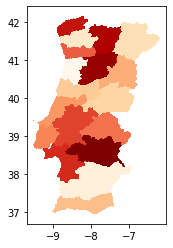

In [6]:
# testing out the data to see how it looks with a cmap
plot = gdf.plot(column='distrito', cmap='OrRd')

fig = plot.get_figure()

In [7]:
# load in new csv file
df = pd.read_csv("/content/drive/My Drive/SIG/pt_covid19.csv", header=0, encoding="utf-8")

df.head()

,id,distrito,24/3/2020,25/3/2020,26/3/2020,27/3/2020,28/3/2020,29/3/2020,30/3/2020,31/3/2020,1/4/2020,2/4/2020,3/4/2020,4/4/2020,5/4/2020,6/4/2020,7/4/2020,8/4/2020,9/4/2020,10/4/2020,11/4/2020,12/4/2020,13/4/2020,14/4/2020,15/4/2020,16/4/2020,17/4/2020,18/4/2020,19/4/2020,20/4/2020,21/4/2020,22/4/2020,23/4/2020,24/4/2020,25/4/2020,26/4/2020,27/4/2020,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020,8/5/2020
0,1,SANTARÉM,17,23,23,23,66,68,100,73,72,88,93,125,130,133,150,160,175,186,186,191,192,206,218,222,226,239,243,243,249,248,262,262,265,286,286,287,287,293,297,300,300,293,300,311,318,320
1,2,FARO,27,30,79,93,91,103,109,124,132,141,152,161,182,211,216,211,230,237,235,245,259,264,278,287,298,294,297,299,310,312,316,318,318,323,324,324,324,321,323,324,325,325,320,323,325,325
2,3,ÉVORA,4,5,8,8,15,23,25,18,20,20,22,22,23,23,23,25,29,29,29,29,29,29,29,28,28,27,24,24,29,33,39,39,40,39,39,39,39,43,43,43,43,43,43,44,44,49
3,4,BRAGA,51,59,212,282,312,421,452,511,584,660,705,788,855,874,968,997,1162,1234,1317,1411,1494,1507,1573,1760,1807,1968,2038,2052,2144,2147,2282,2290,2366,2487,2491,2496,2496,2649,2711,2732,2774,2802,2828,2841,2874,3013
4,5,COIMBRA,40,47,106,140,144,248,295,228,245,269,304,325,325,334,351,359,398,413,414,420,441,470,491,536,566,588,600,606,608,611,634,636,639,693,693,693,693,699,707,707,716,778,894,921,960,965


In [8]:
# filter to include only data labeled as 'Violence Against the Person'
#filtered = df['distrito'] == 'AVEIRO'

#covid19 = df[filtered]

#covid19

df3 = df.groupby('distrito')

df3.head()

,id,distrito,24/3/2020,25/3/2020,26/3/2020,27/3/2020,28/3/2020,29/3/2020,30/3/2020,31/3/2020,1/4/2020,2/4/2020,3/4/2020,4/4/2020,5/4/2020,6/4/2020,7/4/2020,8/4/2020,9/4/2020,10/4/2020,11/4/2020,12/4/2020,13/4/2020,14/4/2020,15/4/2020,16/4/2020,17/4/2020,18/4/2020,19/4/2020,20/4/2020,21/4/2020,22/4/2020,23/4/2020,24/4/2020,25/4/2020,26/4/2020,27/4/2020,28/4/2020,29/4/2020,30/4/2020,1/5/2020,2/5/2020,3/5/2020,4/5/2020,5/5/2020,6/5/2020,7/5/2020,8/5/2020
0,1,SANTARÉM,17,23,23,23,66,68,100,73,72,88,93,125,130,133,150,160,175,186,186,191,192,206,218,222,226,239,243,243,249,248,262,262,265,286,286,287,287,293,297,300,300,293,300,311,318,320
1,2,FARO,27,30,79,93,91,103,109,124,132,141,152,161,182,211,216,211,230,237,235,245,259,264,278,287,298,294,297,299,310,312,316,318,318,323,324,324,324,321,323,324,325,325,320,323,325,325
2,3,ÉVORA,4,5,8,8,15,23,25,18,20,20,22,22,23,23,23,25,29,29,29,29,29,29,29,28,28,27,24,24,29,33,39,39,40,39,39,39,39,43,43,43,43,43,43,44,44,49
3,4,BRAGA,51,59,212,282,312,421,452,511,584,660,705,788,855,874,968,997,1162,1234,1317,1411,1494,1507,1573,1760,1807,1968,2038,2052,2144,2147,2282,2290,2366,2487,2491,2496,2496,2649,2711,2732,2774,2802,2828,2841,2874,3013
4,5,COIMBRA,40,47,106,140,144,248,295,228,245,269,304,325,325,334,351,359,398,413,414,420,441,470,491,536,566,588,600,606,608,611,634,636,639,693,693,693,693,699,707,707,716,778,894,921,960,965
5,6,GUARDA,3,3,0,3,3,38,3,6,3,7,4,4,5,10,131,135,138,140,139,145,158,161,174,188,185,185,180,180,182,182,182,191,189,189,189,190,190,180,181,181,182,185,185,187,187,187
6,7,PORTALEGRE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,4,4,4,7,7,7,7,8,10,13,12,12,14,14,13,13,14,14,14,13,13,13,13,12,12,12,9,13
7,8,LEIRIA,3,3,28,29,39,42,51,38,73,76,98,108,109,114,121,121,129,131,136,144,148,158,157,163,179,181,191,192,205,206,216,216,218,239,240,240,240,245,248,251,252,262,263,266,270,270
8,9,SETÚBAL,80,95,101,101,185,217,245,277,313,341,359,392,411,418,441,457,473,540,548,555,566,571,571,595,609,622,622,628,617,619,635,637,687,719,721,722,722,736,751,761,766,780,798,827,862,881
9,10,VILA REAL,7,12,11,37,111,125,139,140,146,150,150,155,160,160,164,164,167,175,177,182,184,186,202,227,230,234,234,238,245,246,248,248,250,262,262,262,262,259,261,264,267,265,267,268,272,277


In [9]:
# then we need to melt the df so it's in tidy format. reshape the table to keep the columns borough, category, year (as variable) and value
melted = pd.melt(df,  id_vars=['distrito'])

melted.head()

,distrito,variable,value
0,SANTARÉM,id,1
1,FARO,id,2
2,ÉVORA,id,3
3,BRAGA,id,4
4,COIMBRA,id,5


In [10]:
df2 = melted.groupby('distrito')

df2.head()

,distrito,variable,value
0,SANTARÉM,id,1
1,FARO,id,2
2,ÉVORA,id,3
3,BRAGA,id,4
4,COIMBRA,id,5
...,...,...,...
85,VIANA DO CASTELO,27/3/2020,35
86,VISEU,27/3/2020,33
87,BEJA,27/3/2020,0
88,BRAGANÇA,27/3/2020,33


In [11]:
# then let's pivot the dataframe to add on the column 'major_category' and add up the values for each borough by year
covid = gdf.pivot_table(values='nofcases', index=['distrito'], columns='reportdate', aggfunc=np.sum)
covid.columns = covid.columns.get_level_values(0)
covid.head()

reportdate,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08
distrito,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AVEIRO,124,142,311,393,499,652,802,627,728,816,883,966,1011,1023,1112,1148,1180,1325,1392,1415,1448,1491,1593,1703,1732,1780,1815,1824,1820,1823,1884,1888,1905,2075,2076,2076,2076,2142,2162,2183,2204,2254,2268,2276,2294,2322
BEJA,0,0,0,0,0,0,0,0,0,3,6,6,7,7,9,11,11,22,45,45,45,47,57,58,58,58,58,58,62,62,62,65,65,70,70,75,75,97,97,97,97,93,94,95,98,101
BRAGA,51,59,212,282,312,421,452,511,584,660,705,788,855,874,968,997,1162,1234,1317,1411,1494,1507,1573,1760,1807,1968,2038,2052,2144,2147,2282,2290,2366,2487,2491,2496,2496,2649,2711,2732,2774,2802,2828,2841,2874,3013
BRAGANÇA,7,7,27,33,43,59,70,72,74,78,84,84,121,123,141,142,154,157,169,173,174,175,181,182,183,193,203,203,205,205,208,209,208,221,221,221,221,228,230,233,233,230,230,234,239,240
CASTELO BRANCO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,5,5,5,5,5,5,8,11,11,13,14,15,15,16,16,16,16,16,19,19,19,19,19,19,19,19,19,20,20


In [12]:
# join the geodataframe with the cleaned up csv dataframe
merged1 = gdf.set_index('distrito').join(covid)

merged1 = merged1.reindex(merged1.index.rename('distrito'))

merged1.max

<bound method DataFrame.max of            id  reportdate  nofcases  ... 2020-05-06  2020-05-07  2020-05-08
distrito                             ...                                   
AVEIRO    417  2020-04-01       728  ...       2276        2294        2322
AVEIRO    418  2020-05-01      2162  ...       2276        2294        2322
AVEIRO    419  2020-04-02       816  ...       2276        2294        2322
AVEIRO    420  2020-05-02      2183  ...       2276        2294        2322
AVEIRO    421  2020-04-03       883  ...       2276        2294        2322
...       ...         ...       ...  ...        ...         ...         ...
ÉVORA     780  2020-03-29        23  ...         44          44          49
ÉVORA     781  2020-04-29        39  ...         44          44          49
ÉVORA     782  2020-03-30        25  ...         44          44          49
ÉVORA     783  2020-04-30        43  ...         44          44          49
ÉVORA     784  2020-03-31        18  ...         44      

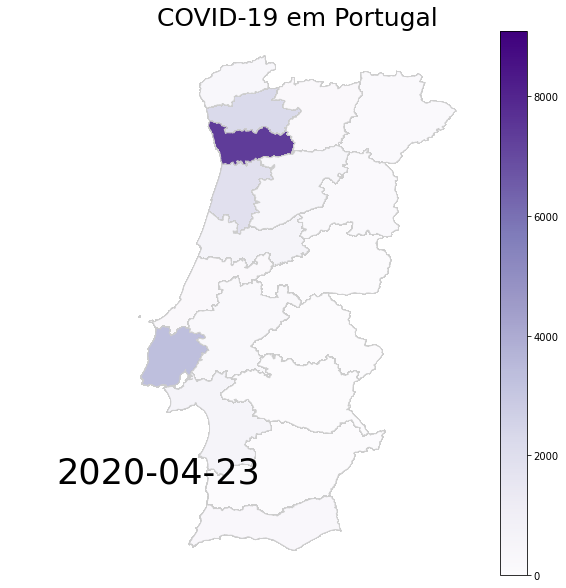

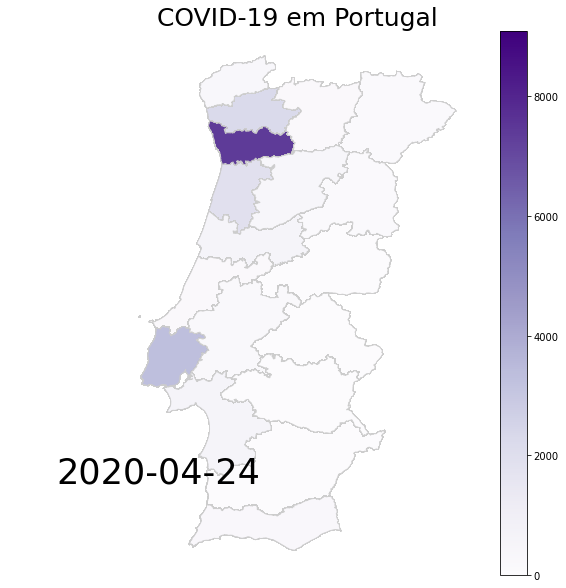

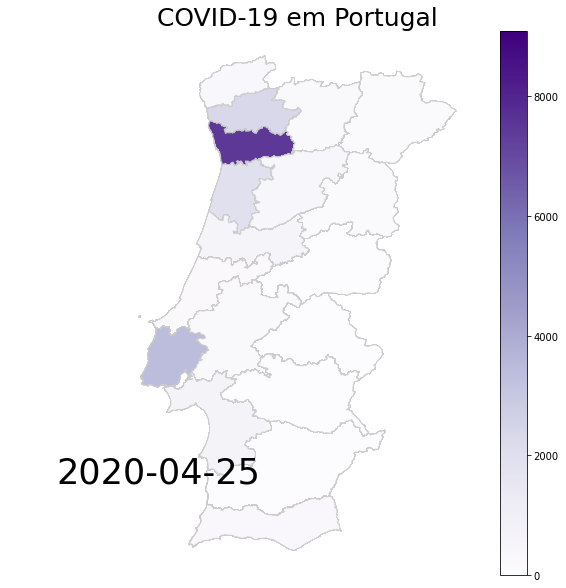

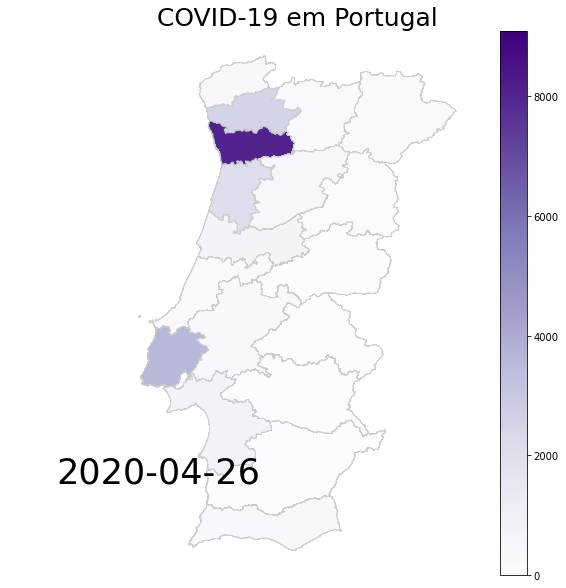

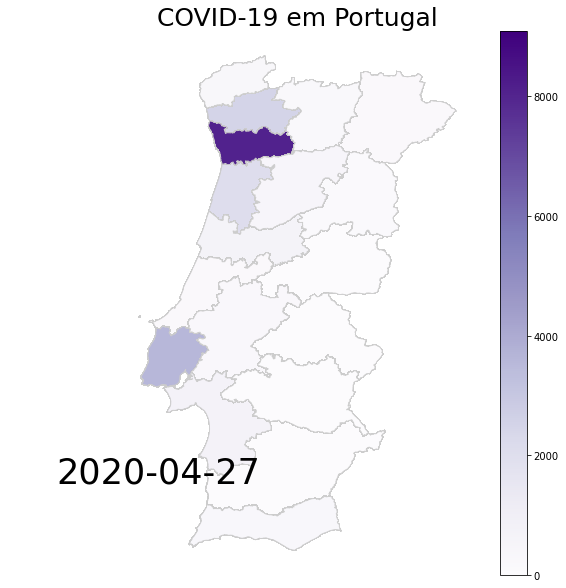

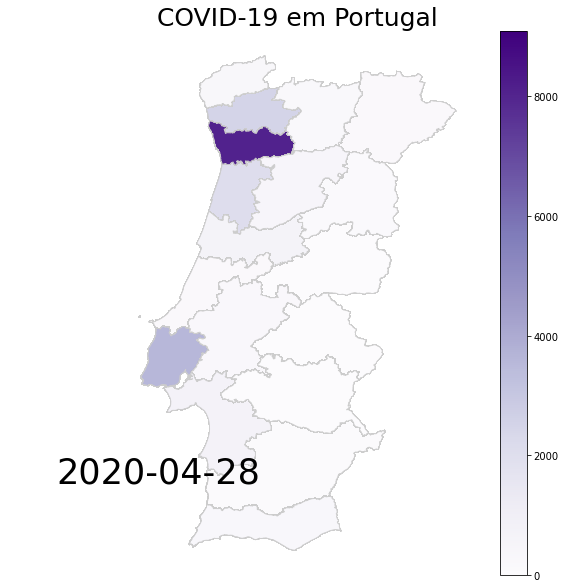

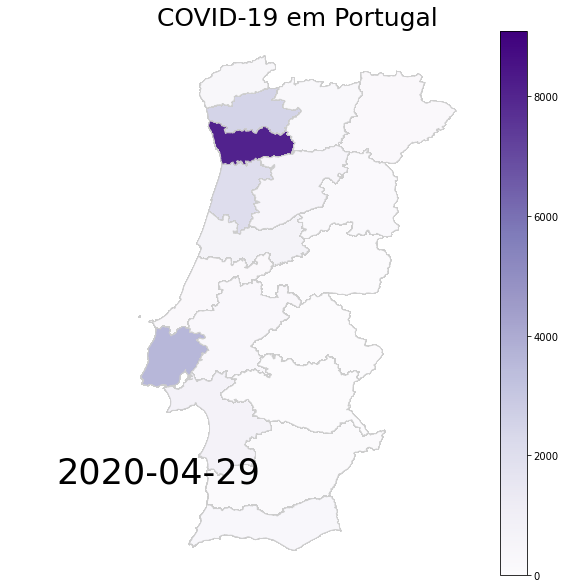

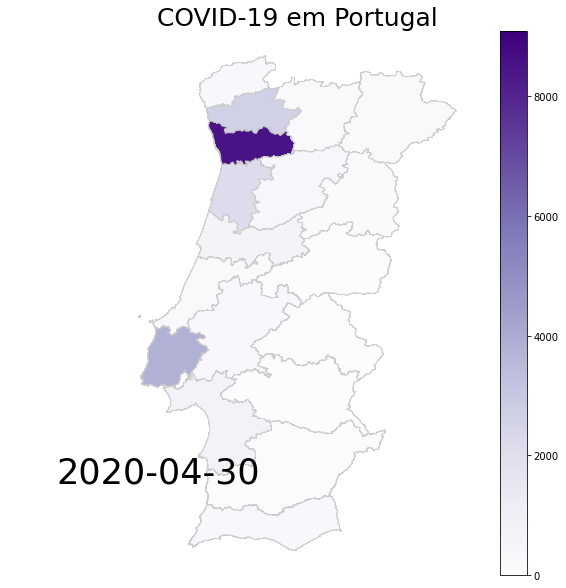

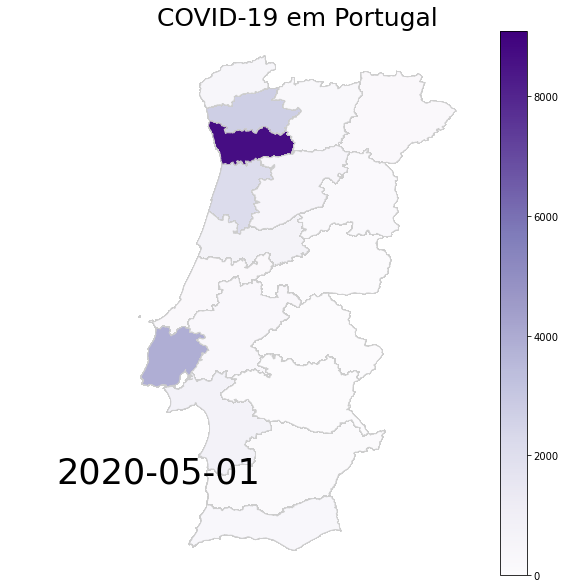

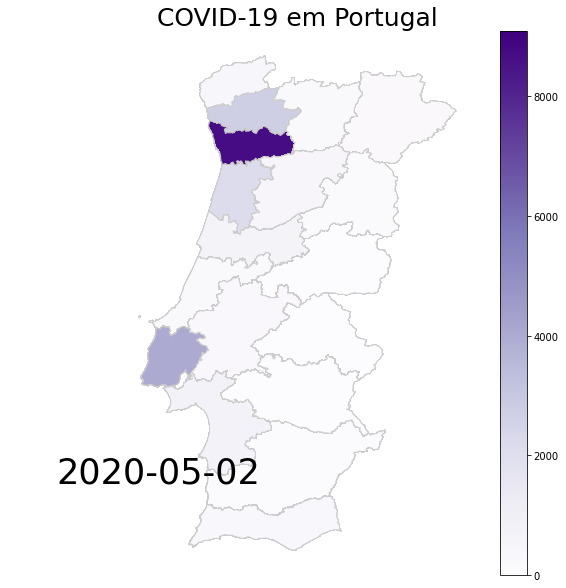

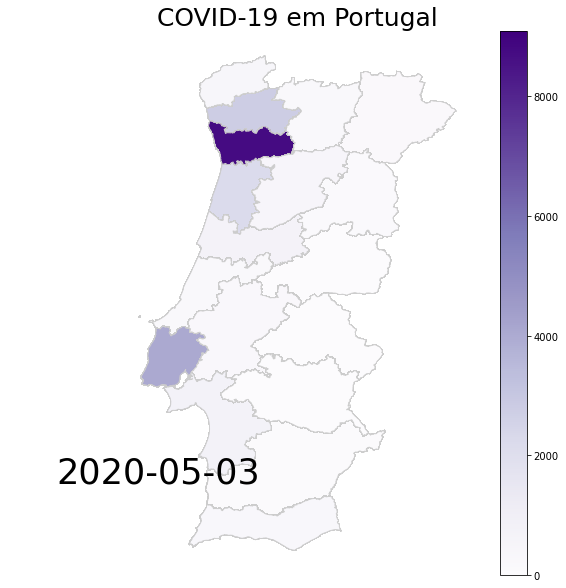

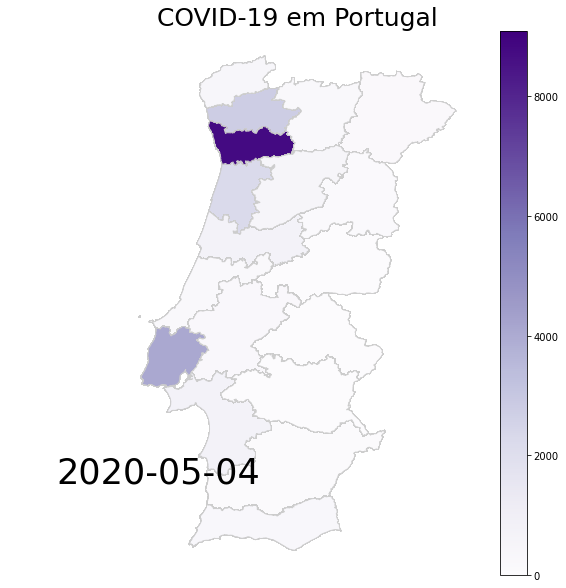

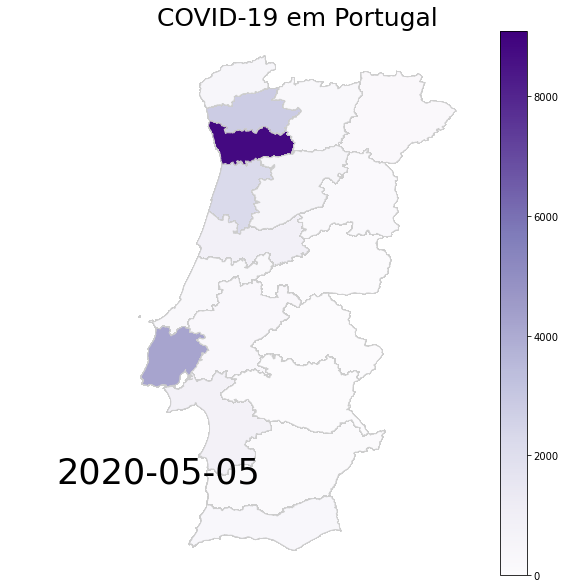

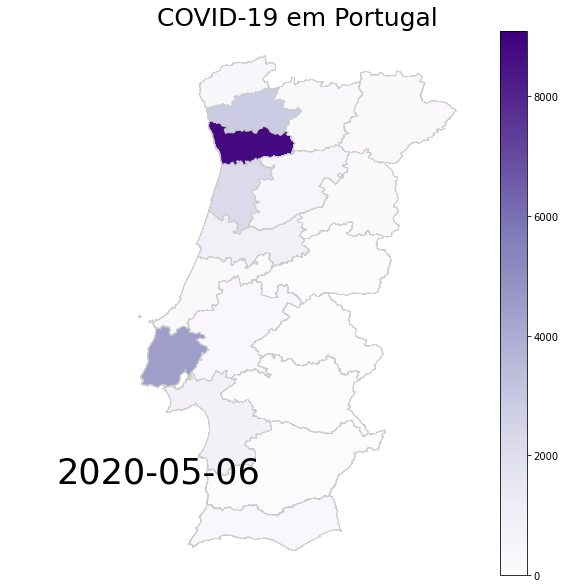

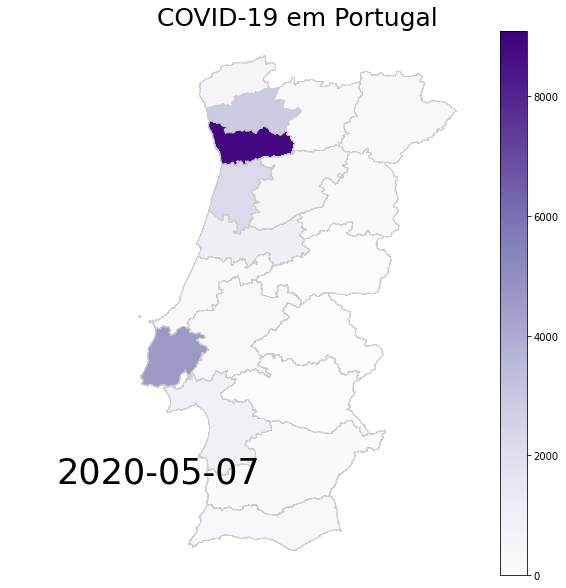

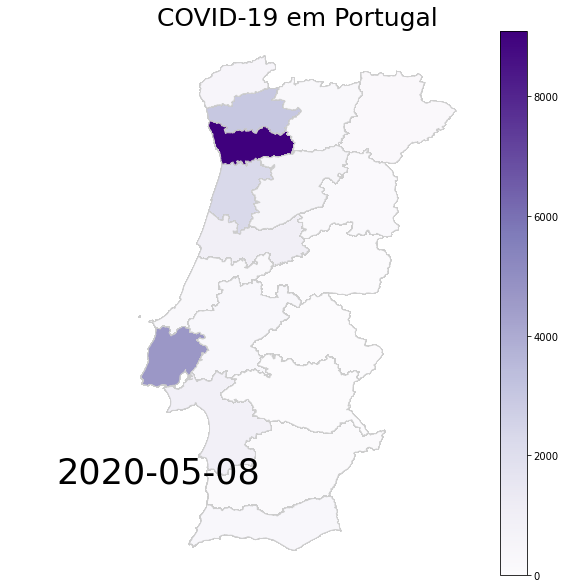

In [13]:
# CREATE A LOOP TO MAKE MULTIPLE MAPS WITH YEAR ANNOTATIONS

# save all the maps in the charts folder
output_path = '/content/drive/My Drive/SIG/charts/maps'

# counter for the for loop
i = 0

# list of days (which are the column names at the moment)
list_of_days = ['2020-04-23',
                '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01',
                '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08']

# set the min and max range for the choropleth map
vmin, vmax = 0, 9090

# start the for loop to create one map per year
for day in list_of_days:
    
    # create map
    fig = merged1.plot(column=day, cmap='Purples', figsize=(10,10), linewidth=0.8, edgecolor='0.8', vmin=0, vmax=9090, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
    
    # UDPATE: added plt.Normalize to keep the legend range the same for all maps
    
    # remove axis of chart
    fig.axis('off')
    
    # add a title
    fig.set_title('COVID-19 em Portugal', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    # create an annotation for the day
    #only_day = (datetime.strptime(day, '%Y-%m-%d'))
    
    # position the annotation to the bottom left
    fig.annotate(day,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    # this will save the figure as a high-res png in the output path. you can also save as svg if you prefer.
    filepath = os.path.join(output_path, day+'_covid.png')
    only_day = (datetime.strptime(day, '%Y-%m-%d')+ timedelta(days=1)).strftime('%Y-%m-%d')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)